In [8]:
import torch
import os
import json
import yaml

from pathlib import Path

In [9]:
origin = Path("outputs/2025-08-28_23-11-36")

for file in origin.iterdir():
    if file.name in ['multirun.yaml', '.submitit']:
        continue

    meta = yaml.safe_load((open(origin / file.name / '.hydra'/ 'overrides.yaml')))
    meta = [att.split(".")[-1] for att in meta]

    meta_title = "_".join(meta)

    exp = origin / file.name / "results.json"

    if exp.exists():
        with open(exp) as f:
            data = json.load(f)

            current, total = 0., 0.
            for k, v in data.items():
                current += float(v.get("success", False))
                total += 1

            print(f"{meta_title} Success Rate: {current / total if total > 0 else 0:.2%}")


num_envs=50_max_steps=20000_chunk_executed=5 Success Rate: 76.00%
num_envs=50_max_steps=2000_chunk_executed=5 Success Rate: 90.00%
num_envs=50_max_steps=2000_chunk_executed=3 Success Rate: 78.00%
num_envs=50_max_steps=200_chunk_executed=5 Success Rate: 90.00%
num_envs=50_max_steps=200_chunk_executed=1 Success Rate: 26.00%
num_envs=50_max_steps=25_chunk_executed=1 Success Rate: 22.00%
num_envs=50_max_steps=20000_chunk_executed=3 Success Rate: 68.00%
num_envs=50_max_steps=25_chunk_executed=5 Success Rate: 82.00%
num_envs=50_max_steps=25_chunk_executed=3 Success Rate: 24.00%
num_envs=50_max_steps=200_chunk_executed=3 Success Rate: 70.00%
num_envs=50_max_steps=20000_chunk_executed=1 Success Rate: 32.00%


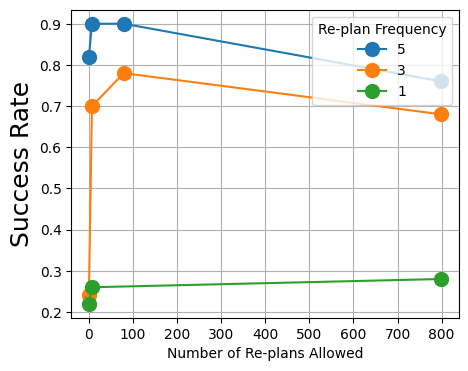

In [10]:
import matplotlib.pyplot as plt
import re

# Raw results (you could load them programmatically instead)
results = [
    ("num_envs=50_max_steps=20000_chunk_executed=5", 0.76),
    ("num_envs=50_max_steps=2000_chunk_executed=5", 0.90),
    ("num_envs=50_max_steps=2000_chunk_executed=3", 0.78),
    ("num_envs=50_max_steps=200_chunk_executed=5", 0.90),
    ("num_envs=50_max_steps=200_chunk_executed=1", 0.26),
    ("num_envs=50_max_steps=25_chunk_executed=1", 0.22),
    ("num_envs=50_max_steps=20000_chunk_executed=3", 0.68),
    ("num_envs=50_max_steps=25_chunk_executed=5", 0.82),
    ("num_envs=50_max_steps=25_chunk_executed=3", 0.24),
    ("num_envs=50_max_steps=200_chunk_executed=3", 0.70),
    ("num_envs=50_max_steps=20000_chunk_executed=1", 0.28),
]

data = []
for meta, success in results:
    # Extract numbers
    m = re.search(r"max_steps=(\d+).*chunk_executed=(\d+)", meta)
    if m:
        max_steps = int(m.group(1))
        chunk = int(m.group(2))
        replan_allowed = max_steps // 25 - 1  # transform as requested
        data.append((replan_allowed, chunk, success))

# Organize by chunk_executed
lines = {}
for replans, chunk, success in data:
    lines.setdefault(chunk, []).append((replans, success))

# Plot
plt.figure(figsize=(5,4))
for chunk, vals in lines.items():
    vals.sort(key=lambda x: x[0])
    xs, ys = zip(*vals)
    plt.plot(xs, ys, marker="o", label=f"{chunk}", markersize=10)

plt.xlabel("Number of Re-plans Allowed")
plt.ylabel("Success Rate", fontsize=18)
plt.legend(title="Re-plan Frequency", loc="upper right")
plt.grid(True)
plt.show()


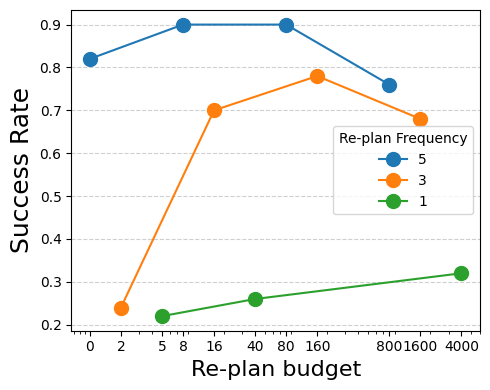

In [11]:
import json
import re
from pathlib import Path
import matplotlib.pyplot as plt

# -------- CONFIG --------
origin = Path("outputs/2025-08-28_23-11-36")
# ------------------------

# Collect (meta_title, success_rate) like your printout, but programmatically
rows = []  # list of (meta_title, success_rate_float)

for file in origin.iterdir():
    if file.name in ['multirun.yaml', '.submitit']:
        continue

    exp_dir = origin / file.name
    results_path = exp_dir / "results.json"
    if not results_path.exists():
        continue

    # Compute success rate for this run
    with open(results_path) as f:
        data = json.load(f)
    current, total = 0.0, 0
    for k, v in data.items():
        current += float(v.get("success", False))
        total += 1
    success_rate = (current / total) if total > 0 else 0.0

    # We can reconstruct the "meta_title" from the directory name if it matches your print,
    # or read hydra overrides to be safe.
    # Try to read hydra overrides to get max_steps and chunk_executed reliably:
    overrides_path = exp_dir / ".hydra" / "overrides.yaml"
    if overrides_path.exists():
        with open(overrides_path) as f:
            overrides = f.read().strip().splitlines()
        # Build a meta string similar to your print
        # and also extract fields
        meta_pieces = []
        max_steps = None
        chunk_executed = None
        for att in overrides:
            last = att.split(".")[-1]
            meta_pieces.append(last)
            # Try to pick out max_steps and chunk_executed
            m1 = re.search(r"max_steps=(\d+)", last)
            if m1:
                max_steps = int(m1.group(1))
            m2 = re.search(r"chunk_executed=(\d+)", last)
            if m2:
                chunk_executed = int(m2.group(1))
        meta_title = "_".join(meta_pieces)
    else:
        # Fallback: parse from dir name if it already contains the fields
        meta_title = file.name
        m1 = re.search(r"max_steps=(\d+)", file.name)
        max_steps = int(m1.group(1)) if m1 else None
        m2 = re.search(r"chunk_executed=(\d+)", file.name)
        chunk_executed = int(m2.group(1)) if m2 else None

    if max_steps is None or chunk_executed is None:
        # Skip if we can't parse needed fields
        continue

    # Define x: Number of Re-plans Allowed
    # To match the nice round numbers you showed (0, 8, 80, 800),
    # we use replans_raw = max_steps // 25, then relabel 1 → "0" on the axis.
    replans_raw = max_steps // 25  # 25 -> 1, 200 -> 8, 2000 -> 80, 20000 -> 800

    if chunk_executed == 1:
        replans_raw *= 5
    elif chunk_executed == 3:
        replans_raw *= 2

    rows.append({
        "meta": meta_title,
        "chunk_executed": chunk_executed,
        "replans_raw": replans_raw,
        "success_rate": success_rate,
    })

# Group by chunk_executed
by_chunk = {}
for r in rows:
    by_chunk.setdefault(r["chunk_executed"], []).append((r["replans_raw"], r["success_rate"]))

# Plot
plt.figure(figsize=(5,4))

# Collect all unique x positions to set ticks nicely later
all_x = set()
for chunk, vals in by_chunk.items():
    vals.sort(key=lambda t: t[0])
    xs = [x for x, _ in vals]
    ys = [y for _, y in vals]

    # Plot on log-scale; 0 cannot be plotted, so we keep x=1 for the smallest bucket
    # and later relabel tick "1" as "0"
    plt.plot(xs, ys, marker="o", markersize=10, label=str(chunk), linewidth=1.5, linestyle="-")
    all_x.update(xs)

plt.xscale("log")
plt.xlabel("Re-plan budget", fontsize=16)
plt.ylabel("Success Rate", fontsize=18)
plt.legend(title="Re-plan Frequency")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# ---- Make a tick that *looks like* 0 on a log axis ----
# We keep the actual data at x=1 (log-safe), but show the tick label "0".
ticks = sorted(all_x)
if 1 not in ticks:
    ticks = [1] + ticks  # ensure 1 is present so we can relabel it as 0

tick_labels = []
for t in ticks:
    if t == 1:
        tick_labels.append("0")  # relabel 1 as 0
    else:
        tick_labels.append(str(t))

plt.xticks(ticks, tick_labels)

plt.tight_layout()
plt.show()


